<a href="https://colab.research.google.com/github/bachvu98/Data-Mining/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, matthews_corrcoef, make_scorer

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Read in the file. This dataset contains 4907 rows and 451 columns. Out of which one is dependent variable and rest 450 are independent variables — physico-chemical characteristics.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/bachvu98/Data-Mining/main/CW_data.csv')
df

,Info_PepID,Info_protein_id,Info_center_pos,Info_AA,Info_window_seq,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,...,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y,Class
0,AAA99570.1:2,AAA99570.1,17,D,NQTTVKADSDNNRSA,3.056565,62,133,23,42,0,1872.85,0.400000,0.800000,0.200000,0.0,0.200000,0.800000,0.266667,0.133333,0.133333,0.356000,-0.528667,0.135333,0.151333,-0.395333,0.035333,0.658667,-0.156000,-0.131333,-0.344667,-0.083333,0.096000,-0.332000,1.922667,-0.211333,-0.048667,-0.870667,0.683333,-0.739400,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.200000,0.000000,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,0.0,1
1,AAA99570.1:2,AAA99570.1,18,S,QTTVKADSDNNRSAS,3.056565,61,132,22,42,0,1845.82,0.466667,0.800000,0.200000,0.0,0.200000,0.800000,0.266667,0.133333,0.133333,0.328667,-0.545333,0.172000,0.129333,-0.462667,0.054000,0.632667,-0.182000,-0.184667,-0.464667,-0.242000,-0.042000,-0.232000,1.878667,-0.390667,-0.041333,-0.886667,0.620667,-0.705133,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.133333,0.000000,0.066667,0.066667,0.200000,0.133333,0.066667,0.0,0.0,1
2,AAA99570.1:2,AAA99570.1,19,D,TTVKADSDNNRSASV,2.923231,61,133,21,41,0,1816.82,0.466667,0.866667,0.266667,0.0,0.266667,0.733333,0.266667,0.133333,0.133333,0.210000,-0.554000,0.188000,0.111333,-0.526000,0.185333,0.532667,-0.222000,-0.278000,-0.592000,-0.190667,-0.070667,-0.033333,1.589333,-0.600000,-0.048000,-0.854000,0.575333,-0.735267,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.133333,0.133333,0.0,0.0,1
3,AAA99570.1:2,AAA99570.1,20,N,TVKADSDNNRSASVK,2.923231,63,138,22,40,0,1843.89,0.400000,0.800000,0.266667,0.0,0.266667,0.733333,0.333333,0.200000,0.133333,0.223333,-0.504667,0.230000,0.071333,-0.424667,0.089333,0.604000,-0.112667,-0.400000,-0.531333,-0.119333,-0.065333,-0.006000,1.692000,-0.395333,-0.139333,-0.657333,0.622667,-0.825600,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.133333,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.066667,0.133333,0.0,0.0,1
4,AAA99570.1:2,AAA99570.1,21,N,VKADSDNNRSASVKK,2.739572,65,143,23,39,0,1870.96,0.333333,0.733333,0.266667,0.0,0.266667,0.733333,0.400000,0.266667,0.133333,0.236667,-0.455333,0.272000,0.031333,-0.323333,-0.006667,0.675333,-0.003333,-0.522000,-0.470667,-0.048000,-0.060000,0.021333,1.794667,-0.190667,-0.230667,-0.460667,0.670000,-0.915933,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.000000,0.133333,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Dataset has only float, integer and object values. No variable column has null/missing values.

Describe the summary statistics for the features

In [5]:
df.describe()

,Info_center_pos,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,feat_F2,feat_F3,feat_F4,feat_F5,...,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y,Class
count,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,...,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,237.800285,2.967125,71.138170,145.627063,20.143061,38.892399,0.144080,1910.216108,0.309014,0.527763,0.291108,0.058420,0.431397,0.568603,0.316555,0.157041,0.159514,0.031674,-0.385500,0.045714,-0.166198,-0.265832,-0.147853,0.316094,-0.094627,-0.419413,-0.039130,-0.111248,-0.048050,-0.026923,0.666622,-0.491523,-0.331989,-0.620221,0.437229,-0.424951,0.095081,-0.231626,0.470484,0.117844,...,0.003574,0.003292,0.004875,0.004844,0.003809,0.007101,0.0,0.006020,0.002022,0.003464,0.003684,0.004060,0.003182,0.0,0.004233,0.003041,0.002978,0.005800,0.002728,0.108702,0.001223,0.067251,0.092263,0.016181,0.044671,0.016752,0.035147,0.106433,0.089600,0.008383,0.049494,0.044345,0.048135,0.033856,0.088364,0.066055,0.057659,0.003736,0.021751,-0.393112
std,261.151590,0.288593,6.766207,11.067443,2.832085,3.027500,0.401062,124.781144,0.145743,0.173096,0.126031,0.072698,0.147883,0.147883,0.164906,0.097903,0.109097,0.247882,0.122471,0.154564,0.346892,0.288143,0.288041,0.280712,0.250174,0.209948,0.293780,0.325023,0.195777,0.248213,0.726510,0.524818,0.406264,0.355932,0.229052,0.266743,0.351862,0.222181,0.214176,0.288024,...,0.016488,0.016692,0.019439,0.019508,0.017329,0.022805,0.0,0.021237,0.012308,0.016909,0.017146,0.017956,0.015709,0.0,0.018739,0.015388,0.015939,0.021468,0.014971,0.089586,0.008946,0.065131,0.094811,0.034078,0.059568,0.035628,0.049063,0.081071,0.073266,0.025351,0.060004,0.068443,0.055030,0.053778,0.084013,0.069178,0.063231,0.016419,0.043248,0.919584
min,1.000000,1.705587,47.000000,110.000000,15.000000,30.000000,0.000000,1499.560000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,-0.760000,-0.716667,-0.442667,-1.268000,-1.206667,-0.924000,-0.749333,-0.829333,-1.188000,-1.042000,-1.196667,-0.816000,-1.010667,-2.766667,-2.494000,-1.775333,-1.593333,-0.533333,-1.267333,-1.011867,-1.034667,-0.221067,-0.548200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [6]:
df.nunique(axis=0)

Info_PepID          194
Info_protein_id     103
Info_center_pos     908
Info_AA              20
Info_window_seq    4013
                   ... 
feat_Perc_T           7
feat_Perc_V           7
feat_Perc_W           3
feat_Perc_Y           5
Class                 2
Length: 451, dtype: int64

Check for missing data

In [7]:
df.isnull().sum()

Info_PepID         0
Info_protein_id    0
Info_center_pos    0
Info_AA            0
Info_window_seq    0
                  ..
feat_Perc_T        0
feat_Perc_V        0
feat_Perc_W        0
feat_Perc_Y        0
Class              0
Length: 451, dtype: int64

In [8]:
X = df.iloc[:,5:450]
y = df['Class']

In [9]:
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns)
X_std

,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,feat_F2,feat_F3,feat_F4,feat_F5,feat_F6,...,feat_CT641,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y
0,0.309949,-1.350698,-1.141036,1.008879,1.026563,-0.359282,-0.299484,0.624350,1.572913,-0.722973,-0.803675,-1.564889,1.564889,-0.302554,-0.242178,-0.239996,1.308523,-1.169098,0.579878,0.915453,-0.449480,0.636038,1.220495,-0.245345,1.372285,-1.040124,0.085895,0.735859,-1.229220,1.729051,0.533934,0.697455,-0.703706,1.074558,-1.178970,-0.797212,-1.076594,-1.059131,-0.917300,0.365384,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,-0.490562,-1.223068,-0.330694,2.508518,-0.647978,0.336781,0.610165,0.535324,0.972634,0.142468,-0.227571,-0.502992
1,0.309949,-1.498506,-1.231400,0.655746,1.026563,-0.359282,-0.516125,1.081822,1.572913,-0.722973,-0.803675,-1.564889,1.564889,-0.302554,-0.242178,-0.239996,1.198244,-1.305199,0.817129,0.852027,-0.683184,0.700850,1.127864,-0.349283,1.118228,-1.448634,-0.402325,0.030906,-0.826299,1.668481,0.192194,0.715507,-0.748663,0.800939,-1.050493,-0.779780,-1.271950,-0.754366,-0.784427,0.517195,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,-0.490562,-1.223068,-0.330694,1.397370,-0.647978,0.336781,0.610165,1.328929,0.972634,0.142468,-0.227571,-0.502992
2,-0.152110,-1.498506,-1.141036,0.302613,0.696223,-0.359282,-0.748556,1.081822,1.958095,-0.193950,-0.803675,-1.114037,1.114037,-0.302554,-0.242178,-0.239996,0.719472,-1.375971,0.920656,0.800132,-0.903004,1.156849,0.771590,-0.509187,0.673629,-1.882109,-0.244372,-0.115534,-0.025830,1.270190,-0.206715,0.699096,-0.656875,0.603002,-1.163472,-0.748704,-1.250044,-0.293326,-0.828178,0.696145,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,-0.490562,-1.223068,-0.330694,1.397370,-0.647978,-0.874792,0.610165,1.328929,0.972634,1.196905,-0.227571,-0.502992
3,-0.152110,-1.202889,-0.689214,0.655746,0.365884,-0.359282,-0.531594,0.624350,1.572913,-0.193950,-0.803675,-1.114037,1.114037,0.101758,0.438835,-0.239996,0.773267,-0.973114,1.192415,0.684810,-0.551292,0.823530,1.025732,-0.072115,0.092475,-1.675584,-0.024877,-0.088290,0.084302,1.411519,0.183301,0.474261,-0.104279,0.809671,-1.502161,-0.555048,-0.981467,-0.295817,-0.894383,0.860112,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,0.331846,-1.223068,-0.330694,1.397370,-0.647978,-0.874792,0.610165,1.328929,0.008839,1.196905,-0.227571,-0.502992
4,-0.788571,-0.907273,-0.23

In [10]:
pca = PCA(n_components=0.99, random_state=0)

In [11]:
pca.fit(X_std)
principalComponents = pca.transform(X_std)
principalComponents

array([[-0.51792927, -7.21279146,  0.78206346, ...,  0.4614281 ,
        -0.74850859,  0.29171932],
       [-1.7165916 , -7.12906427,  1.37404122, ...,  0.11184055,
        -0.24676735,  0.18098246],
       [-3.23001376, -6.05606762,  1.49148812, ...,  0.20553041,
         0.01836545,  0.37179335],
       ...,
       [-2.87824938,  4.48153856,  2.40655691, ...,  0.30189012,
        -0.72440978,  0.21638497],
       [-0.44344111,  5.41627673,  1.36756511, ..., -0.59353205,
         0.06924318,  0.40717544],
       [-2.93262904,  3.67101348,  0.93055805, ..., -0.31685054,
         0.27817704, -0.10917141]])

In [12]:
principalDf = pd.DataFrame(data = principalComponents)
principalDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204
0,-0.517929,-7.212791,0.782063,2.177188,3.075588,5.693814,0.527234,-1.596727,-2.959787,0.110246,0.585247,0.685965,-0.623341,-1.254540,-1.786774,1.894838,1.862695,0.114273,0.515751,0.863435,-0.475900,-2.153035,2.568866,0.933772,1.581914,-0.132303,-0.933705,-0.207782,2.253000,0.875042,1.381155,0.838295,1.224533,1.557420,0.095070,-1.217381,-2.277432,-0.217866,-1.794814,0.215913,...,-1.201743,-0.102912,0.248862,-0.144443,-0.073999,1.451867,0.748893,0.411356,-0.416998,-0.309925,-0.381690,-0.236051,-0.774456,-0.041822,-0.134368,-0.845587,-0.313579,-0.459303,-1.221605,0.441935,0.329147,0.116583,-0.276827,0.329851,0.067533,0.256919,0.200682,-0.147573,-1.173217,0.127106,-0.802107,0.990435,0.319937,-0.689997,-0.234969,0.025413,0.611720,0.461428,-0.748509,0.291719
1,-1.716592,-7.129064,1.374041,2.373714,2.360851,5.353468,-0.941388,-1.337473,-2.547389,-0.151943,0.668973,0.494845,-0.131652,-1.902438,-1.707597,1.783559,1.302411,0.257567,0.955095,0.550600,-0.171415,-1.536315,2.584061,0.992466,2.106091,-0.113030,-0.847433,0.107750,2.301344,1.318601,1.314922,0.580736,1.641517,1.230837,-0.597024,-1.663677,-2.347285,-0.010684,-1.368054,0.288640,...,-0.975795,0.086188,0.345629,-0.075146,0.222237,1.089035,0.834622,0.811545,-0.825684,0.017003,-0.354745,-0.489209,-0.127194,-0.162280,0.015335,-0.951870,-0.365651,-0.098788,-1.161824,-0.013000,0.299766,0.009775,-0.989678,0.146057,0.531179,-0.769163,-0.453075,-0.349685,-1.036658,0.171974,-1.024775,0.623537,0.572584,-0.610781,-0.015811,-0.008826,0.524865,0.111841,-0.246767,0.180982
2,-3.230014,-6.056068,1.491488,1.482711,2.006149,5.042231,-1.849560,-2.126175,-3.411762,-0.467480,0.855345,0.657608,0.148551,-2.355742,-1.245325,2.498343,1.219487,0.521128,0.177275,0.796648,-0.159068,-1.446803,2.533040,0.494726,2.408259,0.112921,-0.968517,0.704509,2.499180,1.511700,1.521707,0.275036,1.128322,0.915516,-0.704627,-1.962136,-2.417837,0.524748,-1.868283,0.783757,...,-1.399911,0.103721,0.382245,0.161098,0.338048,0.621787,1.033081,0.595000,-0.644793,-0.069105,-0.428855,-0.615153,0.210700,-0.163637,-0.477487,-0.785425,-0.292289,-0.597743,-0.930506,-0.247642,0.270583,-0.389086,-0.707557,0.221158,0.919594,-0.745526,-0.602165,-0.293884,-0.576487,0.298388,-0.878672,0.733702,0.269305,0.048683,-0.125921,0.109833,-0.001622,0.205530,0.018365,0.371793
3,-1.235076,-4.631192,2.280601,2.409877,1.853643,4.473048,-1.375321,-2.217120,-4.040747,-0.506112,0.967636,0.711953,-0.315351,-2.470194,-1.308386,2.970633,1.688819,0.644120,0.666201,1.076814,-0.244347,-1.688849,2.808088,0.469428,2.519114,0.203769,-1.031617,0.931562,2.395938,1.284852,1.757723,0.004739,1.389897,1.418259,-1.048624,-2.379693,-2.352713,0.929198,-2.549425,1.103602,...,-1.012505,-0.469757,0.648455,-0.099048,0.418801,0.550990,0.770028,-0.111765,-1.046245,0.358776,0.100814,-0.592350,0.217327,-0.025883,-1.315161,-1.100964,-0.307693,-0.326849,-1.431111,-0.595148,0.736198,-0.626942,-0.937719,0.423141,0.558295,-0.782958,-0.270913,-0.397325,-0.672739,0.225094,-0.630920,0.015455,0.311062,-0.346175,0.368521,-0.065204,0.163881,0.063174,0.169299,0.007271
4,0.685001,-3.204052,3.327720,3.172147,1.416146,3.615925,-0.824375,-2.560105,-3.599366,-0.862474,0.962423,-0.039225,-0.842831,-2.193707,-0.969875,3.105871,1.868733,0.753552,0.620235,1.026068,0.003479,-2.231504,2.950356,0.661198,2.426779,-0.050569,-0.830197,1.137940,2.006631,1.411593,1.391531,-0.205596,1.599960,1.171640,-1.297043,-1.810261,-2.096380,0.951979,-2.087446,0.040796,...,-0.815785,-0.284563,0.721588,0.245179,0.060802,0.727336,0.844309,0.245405,-0.765116,-0.013807,-0.042718,-0.185159,-0.064170,-0.406893,-1.726114,-0.309196,0.084528,-0.341808,-1.332278,-0.993319,0.746966,-0.100369,-0.533105,0.667406,0.659293,-0.381677,-0.728069,-0.801032,-0.830399,0.1717

In [13]:
print(pca.n_components_)
print(sum(pca.explained_variance_ratio_))

205
0.9902328772020959


In [14]:
X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size=0.25, stratify=df['Info_PepID'].values, shuffle=True, random_state=0)

In [15]:
print('\nBalance of positive and negative classes (%):')
y_train.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


-1    69.836957
 1    30.163043
Name: Class, dtype: float64

In [21]:
clf = KNeighborsClassifier(n_neighbors=7)
start_time = time.time()
clf.fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Done training in 0.08453583717346191 seconds.


In [22]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

In [20]:
ftwo_scorer = make_scorer(matthews_corrcoef)
imba_pipeline = make_pipeline(SMOTE(random_state=0), SVC(random_state=0))
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
params = {"C": [1,2,3,4,5,6,7,8,9,10]}
new_params = {'svc__' + key: params[key] for key in params}
clf = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=ftwo_scorer,n_jobs=-1, return_train_score=True).fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

KeyboardInterrupt: ignored

In [25]:
ftwo_scorer = make_scorer(matthews_corrcoef)
model = SVC(random_state=0)
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
knnparams = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10],
          "weights": ['uniform', 'distance'],
          "metric": ['euclidian', 'manhattan', 'minkowski']}
svcparams = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Done training in 193.6756935119629 seconds.


In [23]:
results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

AttributeError: ignored

In [ ]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.8890477915148434
0.017938626735651074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


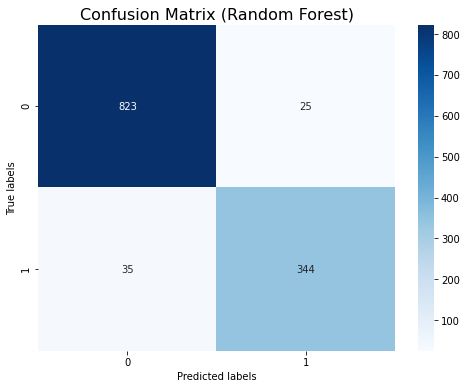

              precision    recall  f1-score   support

          -1       0.96      0.97      0.96       848
           1       0.93      0.91      0.92       379

    accuracy                           0.95      1227
   macro avg       0.95      0.94      0.94      1227
weighted avg       0.95      0.95      0.95      1227

MCC Score=0.885


In [24]:
preds = clf.predict(X_test)
#preds_proba = clf.predict_proba(X_test)
#preds_proba = preds_proba[:, 1]

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

#precision, recall, thresholds = precision_recall_curve(y_test, preds_proba)
#AUC = auc(recall, precision)
#print('AUPRC Score=%.3f' % AUC)

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))